# Nepalese character recognition
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from the Devanagari script. Our goal is to learn to _read_ these letters, i.e. learn to recognize the right letter given the image.

In [2]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

import time
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from random import randint

We first download the data from OpenML. Then, we select a few images, and show them together with their correct classification

In [3]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

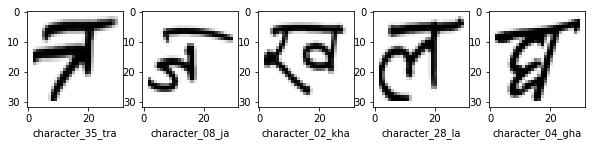

In [3]:
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((classes[y[n]]))
plt.show();

## Learning curves
This is a rather large dataset. We'll first plot the learning curves (performance vs sample size) for different learning algorithms. This will show us whether the algorithms keep improving with more data, or whether the returns diminish (curves level off). We also plot the training time to see the training time vs. accuracy trade-off. Given the size of the dataset, we use a holdout rather than cross-validation.

In [ ]:
# One big evaluation loop. Takes about 5 hours to run.
sample_sizes = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Models
logreg = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
models = [logreg, knn, rf]
run_model = {logreg: True, knn: True, random: True} # To stop slow models

# Result dataframe
modelname_list = []
sample_size_list = []
running_times_list = []
train_score_list = []
test_score_list = []
evals = pd.DataFrame(
        {'algorithm': modelname_list,
         'sample_size': sample_size_list,
         'training_time': running_times_list,
         'train_score' : train_score_list,
         'test_score' : test_score_list,
        })

# Start the Loop
for sample_size in sample_sizes:
    if any(v == True for v in run_model.values()): # Stop if no models survive
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)
        for model in models:
            if run_model[model]: # Only run survivors
                modelname_list.append(model.__class__.__name__)
                sample_size_list.append(sample_size)
                start_time = time.time()
                model.fit(X_train, y_train)
                running_times_list.append(time.time() - start_time)
                train_score_list.append(model.score(X_train, y_train))
                test_score_list.append(model.score(X_test, y_test)) 
                # TODO: measure prediction time as well
                if time.time() - start_time > 300: # Training takes too long (more than 5 minutes). Kick model out.
                    run_model[model] = False
                    print(model.__class__.__name__,"takes too long. Stopping at",sample_size)

We plot the results in one plot per algorithm:

**Logistic Regression**: Slow to train! The training time increases exponentially. Stopped after a 15% subsample. At that point, the model was still severely overfitting (training score 100%, testing score 45%). To use this model, we should regularize it (with the $alpha$ parameter), but it will remain slow.

**K Nearest Neighbor**: Training time increases fast (exponential), but of course for kNN we should also take prediction time into account. It has good performance on relatively small samples. Giving it more data yields further, but smaller, improvements. Overfitting is not so bad. 

**RandomForest**: Similar test set scores as K Nearest Neighbors, but training time is almost linear. Moreover, it's almost as fast as kNN, even though RandomForests build trees while a kNN only needs to store data points in a data structure (e.g. a KDtree). It does seems to overfit more (training set accuracy is 100%).

Note: the runtimes show some outliers, but these can probably be ignored.

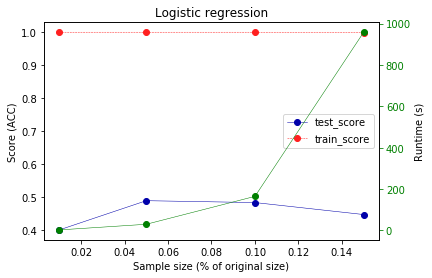

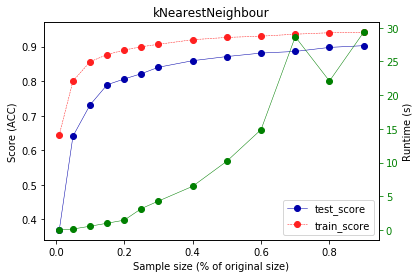

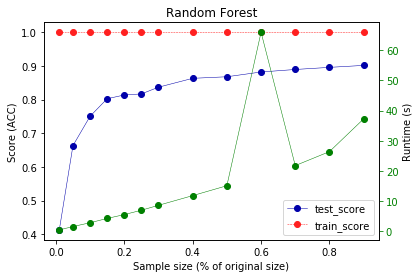

In [22]:
for model in models:
    eval_m = evals[evals['algorithm'] == model.__class__.__name__]
    plt.figure()
    plt.plot(eval_m['sample_size'], eval_m['test_score'], marker = 'o')
    plt.plot(eval_m['sample_size'], eval_m['train_score'], marker = 'o')
    ax = plt.gca()
    ax.set_ylabel('Score (ACC)')

    ax2 = ax.twinx()
    ax2.plot(eval_m['sample_size'], eval_m['training_time'], marker = 'o', color='g')
    ax2.set_ylabel('Runtime (s)')
    ax2.tick_params('y', colors='g')
    ax.set_xlabel('Sample size (% of original size)')

    ax.legend()
    plt.title(model.__class__.__name__)

## Tuning hyperparameters
Since both the kNN and RandomForest seem to overfit, we should optimize their hyperparameters. 

First, we optimize the number of trees in the forest with a simple grid search and plot the result.
We do this on a 10% stratified subset to save time. The results show (not surprisingly) that more estimators lesad to better performance, although the gains are very minimal beyond 300 trees.

In [ ]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=0)
param_grid = {'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]}
grid_search_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=10)
grid_search_rf.fit(X_sample, y_sample);

Best configuration:{'n_estimators': 500}
Best score (ACC):0.802065217391


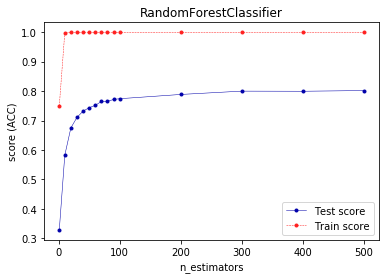

In [49]:
def plot_tuning(grid_search, param_name): # Generic plot for 1D grid search
    plt.figure()
    plt.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    plt.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax = plt.gca()
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    plt.title(grid_search_rf.best_estimator_.__class__.__name__)
    print('Best configuration:' + str(grid_search.best_params_))
    print('Best score (ACC):' + str(grid_search.best_score_))
    
plot_tuning(grid_search_rf, 'n_estimators');

Next, we optimize the number of neighbors in kNN and plot the result.
The results show that it is best to use only 1 nearest neighbor. Given that this is a very high-dimensional dataset (1024 features), and that we use a 10% subsample, the space in which to look for nearest neighbors is very sparse and there may not be much regularization from including more neighbors.

Best configuration:{'n_neighbors': 1}
Best score (ACC):0.790869565217


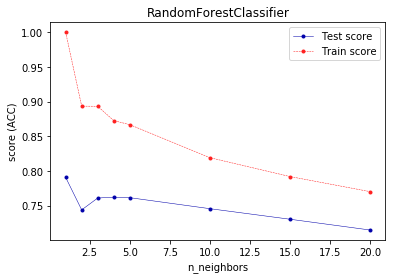

In [89]:
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, cv=10)
grid_search_knn.fit(X_sample, y_sample);
plot_tuning(grid_search_knn, 'n_neighbors');

## RandomForest hyperparameter tuning
RandomForest seem to be a good model to stick to. Let's try to find even better hyperparameters by tuning the two most important hyperparameters, $n\_estimators$ and $max\_features$, simultaneously on the entire dataset.

First, we do a simple grid search and plot the result:

In [4]:
param_dist = {"max_features": np.logspace(0, 7, 8, base=2).astype(int),
              "n_estimators" : np.logspace(0, 8, 9, base=2).astype(int)}
grid_search_rf2 = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_dist, cv=10, n_jobs=-1)
grid_search_rf2.fit(X, y);
print('Best configuration:', grid_search_rf2.best_params_)

Best configuration: {'max_features': 64, 'n_estimators': 256}


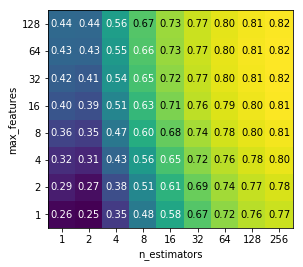

In [7]:
# Plotting the heatmap
scores = np.array(grid_search_rf2.cv_results_['mean_test_score']).reshape(8,9)
mglearn.tools.heatmap(scores, xlabel='n_estimators', xticklabels=param_dist['n_estimators'],
                      ylabel='max_features', yticklabels=param_dist['max_features'], cmap="viridis");

Simply taking the maximum score is very optimistic. To get a better estimate, we do a nested cross-validation, with an outer 5-fold CV, and an inner random search (200 iterations) optimizing hyperparameters according to a 3-fold CV. Note: this took a really long time. It would make sense to use fewer outer loops.

In [ ]:
from scipy.stats import expon, uniform # Use a distribution instead of a grid
param_dist = {"max_features": uniform(0.0001,1),
              "n_estimators" : np.random.geometric(p=0.01, size=100)}
scores = cross_val_score(RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, 
                                            n_iter=200, cv=3), X, y, cv=5, n_jobs=-1);
print('Estimated performance of an optimized RandomForest: {:.3f}'.format(scores.mean()))